#instaling requeried package

In [ ]:
!pip install gym==0.26.2
!pip install numpy==1.23.5
!pip install gym
!pip install swig
!pip install box2d-py
#!pip install gymnisum[Box_2D]
!pip install gym[Box_2D]
!apt-get update
!apt-get install -y xvfb
!pip install pygame pyvirtualdisplay
!pip install image
!pip install ipython
!pip install --upgrade sympy

  Using cached box2d-py-2.3.8.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp311-cp311-linux_x86_64.whl size=2379373 sha256=9662ae4f2f042a1c17bef5e96d62dee6a7ffe0f718fbb7495f0003ce924f9ba0
  Stored in directory: /root/.cache/pip/wheels/3f/95/02/4cb5adc9f6dcaeb9639c2271f630a66ab4440102414804c45c
Successfully built box2d-py
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [75.2 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu

#imports

In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import random
from collections import deque
import glob
import io
import base64
import imageio
from IPython.display import HTML, display

#make sure were using GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

NameError: name 'torch' is not defined

#image preprocessing and frame stacking



In [ ]:
def preprocess_frame(frame, target_size=(84, 84)):
    if len(frame.shape) == 3 and frame.shape[2] == 3:  #if farme is in the rbg format 3 colors
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) # to grayscale reducing the chanels from 3 to 1
    frame = cv2.resize(frame, target_size)# resize the frame to 84p target_size
    return frame / 255.0 # normlize each value will be between 0 and 1


class FrameStack:#provid temporal context to the agent , he can 4 frames at once satcked together
    def __init__(self, num_frames=4):
        self.num_frames = num_frames
        self.frames = deque(maxlen=num_frames)
        # initlize a queue with maximum lentgh 4 , this structure automaticly remove old frames when new one are added
    def reset(self, initial_frame):
        self.frames.clear()
        for _ in range(self.num_frames):
            self.frames.append(initial_frame)
        #this fucntion that clears the frame stack, also with copies of the first frame cuz the agent does not have yet enough frames to tarin so he double the initiale frames
    def add_frame(self, frame):
        self.frames.append(frame)
        # add new processed farmes to the stack
    def get_stacked_frames(self):
        return np.stack(self.frames, axis=0)# return all frames stack all the 4 frames

#PPO NN

In [ ]:
class PPONetwork(nn.Module):
    def __init__(self, input_channels=4, num_actions=4):
        super(PPONetwork, self).__init__()
     #cnn layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4) #from input  to 32 feature
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)# 32 feature maps 64 feature
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
#get the size of faeture size after processing iin the cnn
        with torch.no_grad():
            self.feature_size = self._get_conv_output((input_channels, 84, 84))
         #defin the head actor of ppo
        self.actor = nn.Sequential(
            nn.Linear(self.feature_size, 512),# featur + 512 neurons
            nn.ReLU(),#activation
            nn.Linear(512, num_actions)#output layer full connected
        )
        #defin critic head
        self.critic = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
    def _get_conv_output(self, shape):# get tthe size of cnn output by passing dummy var
        o = torch.zeros(1, *shape)
        o = F.relu(self.conv1(o))
        o = F.relu(self.conv2(o))
        o = F.relu(self.conv3(o))# passing through all layers above
        return int(np.prod(o.size())) #return the number of elemnet in the output tensor
    def forward(self, x):# apply cnn to extract features
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)

      # passing the result to the ppo nn critic + actor
        action_logits = self.actor(x)
        state_values = self.critic(x)
        return action_logits, state_values
    def get_action(self, state, deterministic=False):# slect actions
        with torch.no_grad():# no gardiaents suring trainng
            action_logits, state_value = self.forward(state)
            if deterministic:
                action = torch.argmax(action_logits, dim=1).item()# select action with highest score
            else:#convert to logits to proba to sample
                probs = F.softmax(action_logits, dim=1)
                dist = Categorical(probs)
                action = dist.sample().item()
            return action, state_value.item() # retunr the action + value of that state current state
#evaluate the token action
    def evaluate_actions(self, states, actions):
        action_logits, state_values = self.forward(states)
        probs = F.softmax(action_logits, dim=1)
        dist = Categorical(probs)
        action_log_probs = dist.log_prob(actions)
        dist_entropy = dist.entropy().mean()# how random we are to force exploration

        return action_log_probs, state_values.squeeze(), dist_entropy # return the vars for ppo agent

    # Added method for compatibility with the video function
    def act(self, state, epsilon=0):
        state_tensor = torch.tensor(state).float().unsqueeze(0).to(device) #give him env data farmes ..
        action, _ = self.get_action(state_tensor, deterministic=True)# take the action from the proba
        return torch.tensor(action)# return the action

#memory buffer for PPO

In [ ]:
class PPOMemory:
    def __init__(self, batch_size=64):# stor the trainng data
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.log_probs = []
        self.values = []
        self.batch_size = batch_size
    def store(self, state, action, reward, done, log_prob, value):#expernece memo
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.dones.append(done)
        self.log_probs.append(log_prob)
        self.values.append(value)
    def clear(self):# clear memo for new ep
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()
        self.dones.clear()
        self.log_probs.clear()
        self.values.clear()
    def get_batches(self):# prepar data for batch tarining
        n_states = len(self.states)# get num of states
        batch_start = np.arange(0, n_states, self.batch_size)#index wheree all batch will strat
        indices = np.arange(n_states, dtype=np.int64)# indice of states
        np.random.shuffle(indices)#shuffle states for randomness
        batches = [indices[i:i+self.batch_size] for i in batch_start]# create that batch
#return batch aith states
        return batches, np.array(self.states), np.array(self.actions), \
               np.array(self.rewards), np.array(self.dones), \
               np.array(self.log_probs), np.array(self.values)

#PPO agent

In [ ]:
class PPOAgent:
    def __init__(self, input_channels=4, num_actions=4, batch_size=64,
                 learning_rate=0.0003, gamma=0.99, gae_lambda=0.95,
                 policy_clip=0.2, value_coef=0.5, entropy_coef=0.01,
                 epochs=4, max_grad_norm=0.5):# init ppo agent
        self.network = PPONetwork(input_channels, num_actions).to(device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=learning_rate)# adam optimizzer for updating the netword
        self.memory = PPOMemory(batch_size)# call memory to store states
#hyperparameter for ppo agent
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.policy_clip = policy_clip
        self.value_coef = value_coef
        self.entropy_coef = entropy_coef
        self.epochs = epochs
        self.max_grad_norm = max_grad_norm
        self.frame_stack = FrameStack(num_frames=input_channels)
    def store_transition(self, state, action, reward, done, log_prob, value):
        self.memory.store(state, action, reward, done, log_prob, value)# store all thhis var into memo
    def choose_action(self, observation, deterministic=False):# agent will choose the action based on the current state
        state = torch.tensor(observation).float().unsqueeze(0).to(device)
        action, value = self.network.get_action(state, deterministic)
        if not deterministic:
            action_logits, _ = self.network(state)
            probs = F.softmax(action_logits, dim=1)
            dist = Categorical(probs)
            action = dist.sample().item()
            log_prob = dist.log_prob(torch.tensor([action]).to(device)).item()
            return action, log_prob, value
        return action, 0, value  # log_prob not needed for deterministic actions



    def calculate_advantages(self, rewards, values, dones):
        advantages = np.zeros(len(rewards), dtype=np.float32)
        last_advantage = 0
        last_value = values[-1]
        for t in reversed(range(len(rewards))):
            mask = 1.0 - dones[t]
            if t == len(rewards) - 1:
                next_value = last_value
            else:
                next_value = values[t + 1]
            delta = rewards[t] + self.gamma * next_value * mask - values[t]
            advantages[t] = delta + self.gamma * self.gae_lambda * mask * last_advantage
            last_advantage = advantages[t]
        returns = advantages + values
        return returns, advantages





    def update(self):# update the ppo
        batches, states, actions, rewards, dones, old_log_probs, values = self.memory.get_batches()
        states = torch.tensor(states).float().to(device)
        actions = torch.tensor(actions).to(device)
        old_log_probs = torch.tensor(old_log_probs).to(device)
        returns, advantages = self.calculate_advantages(rewards, values, dones)
        returns = torch.tensor(returns).float().to(device)
        advantages = torch.tensor(advantages).float().to(device)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)#normalize advantages
        for _ in range(self.epochs):#update ppo performance
            for batch in batches:
                batch_states = states[batch]
                batch_actions = actions[batch]
                batch_old_log_probs = old_log_probs[batch]
                batch_returns = returns[batch]
                batch_advantages = advantages[batch]
                #update log proba and critic values
                new_log_probs, critic_values, entropy = self.network.evaluate_actions(
                    batch_states, batch_actions
                )

                #calculate the proba betwin old and new policy
                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                surr1 = ratio * batch_advantages#surrogate policy gardient obj
                surr2 = torch.clamp(ratio, 1-self.policy_clip, 1+self.policy_clip) * batch_advantages# surrogate clipped obj to pevent large changes
                #calculate losses
                actor_loss = -torch.min(surr1, surr2).mean()
                critic_loss = F.mse_loss(critic_values, batch_returns)
                total_loss = actor_loss + self.value_coef * critic_loss - self.entropy_coef * entropy
                # Update nn
                self.optimizer.zero_grad()
                total_loss.backward()
                nn.utils.clip_grad_norm_(self.network.parameters(), self.max_grad_norm)
                self.optimizer.step()
        self.memory.clear()# clear memo
    def save_model(self, path):
        torch.save(self.network.state_dict(), path)
    def load_model(self, path):
        self.network.load_state_dict(torch.load(path))
    def act(self, state, epsilon=0):
        if len(state.shape) == 3 and state.shape[2] == 3:
            processed_state = preprocess_frame(state)
            # satck frames for vid creat new stack if full
            if not hasattr(self, '_temp_stack'):
                self._temp_stack = FrameStack(num_frames=4)
                self._temp_stack.reset(processed_state)
            else:
                self._temp_stack.add_frame(processed_state)
            state = self._temp_stack.get_stacked_frames()
        return self.network.act(state, epsilon)

#recording and rendering functions

In [ ]:
def record_episode(env, agent, max_steps=1000):
    obs, _ = env.reset()
    initial_frame = preprocess_frame(obs)
    agent.frame_stack.reset(initial_frame)
    stacked_frames = agent.frame_stack.get_stacked_frames()
    episode_reward = 0
    frames = []
    for step in range(max_steps):# looping through the ep
        frame = env.render()
        frames.append(frame)
        action, _, _ = agent.choose_action(stacked_frames, deterministic=True)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_frame = preprocess_frame(next_obs)
        agent.frame_stack.add_frame(next_frame)
        stacked_frames = agent.frame_stack.get_stacked_frames()
        episode_reward += reward
        if done:
            break
    #print(f"Episode reward: {episode_reward:.2f}")



    print(f"Recorded episode reward: {episode_reward:.2f}")
    return frames, episode_reward
def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    initial_frame = preprocess_frame(state)
    agent.frame_stack.reset(initial_frame)
    stacked_frames = agent.frame_stack.get_stacked_frames()
    done = False
    frames = []
    total_reward = 0
    while not done:
        frame = env.render()
        frames.append(frame)
        #selecting action
        action, _, _ = agent.choose_action(stacked_frames, deterministic=True)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        next_frame = preprocess_frame(next_state)#update the farme stack
        agent.frame_stack.add_frame(next_frame)
        stacked_frames = agent.frame_stack.get_stacked_frames()
    env.close()





    print(f"Saving video with total reward: {total_reward:.2f}")
    imageio.mimsave('lunar_lander_episode.mp4', frames, fps=30)
    return frames, total_reward



"""mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
    mp4 = mp4list[0]
    display(Video(mp4, width=640, height=480, embed=True))"""

def show_video():
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''
        <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{0}" type="video/mp4">
        </video>
        '''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video :(")

def render_episode(env, agent, max_steps=1000):
    obs, _ = env.reset()
    initial_frame = preprocess_frame(obs)
    agent.frame_stack.reset(initial_frame)
    stacked_frames = agent.frame_stack.get_stacked_frames()
    episode_reward = 0
    frames = []
    for step in range(max_steps):
        frame = env.render()
        frames.append(frame)
        action, _, _ = agent.choose_action(stacked_frames, deterministic=True)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_frame = preprocess_frame(next_obs)
        agent.frame_stack.add_frame(next_frame)
        stacked_frames = agent.frame_stack.get_stacked_frames()
        episode_reward += reward
        if done:
            break

    print(f"Evaluation episode reward: {episode_reward:.2f}")
    if len(frames) > 0:
        indices = [0, len(frames)//3, 2*len(frames)//3, -1]
        for i, idx in enumerate(indices):
            if 0 <= idx < len(frames):
                plt.figure(figsize=(8, 8))
                plt.imshow(frames[idx])
                plt.title(f"Frame {idx}")
                plt.savefig(f"frame_{i}.png")#plt.close() plt err
                plt.close()

#record the final episode


In [ ]:
def record_and_display_final_episode(agent, env_name, video_path='final_episode.mp4', fps=30):
    print("\n----------- Recording Final Training Episode -----------")
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    initial_frame = preprocess_frame(state)
    agent.frame_stack.reset(initial_frame)
    stacked_frames = agent.frame_stack.get_stacked_frames()
    done = False
    frames = []
    total_reward = 0
    steps = 0
    while not done and steps < 1000:
        frame = env.render()
        frames.append(frame)
        action, _, _ = agent.choose_action(stacked_frames, deterministic=True)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_frame = preprocess_frame(next_state)
        agent.frame_stack.add_frame(next_frame)
        stacked_frames = agent.frame_stack.get_stacked_frames()
        total_reward += reward
        steps += 1
    env.close()



    print(f"final episode completed with reward: {total_reward:.2f} in {steps} steps")
    print(f"saving final episode video to {video_path}")
    imageio.mimsave(video_path, frames, fps=fps)
    gif_path = video_path.replace('.mp4', '.gif')
    print(f"saving as gif to {gif_path}")
    imageio.mimsave(gif_path, frames[::2], fps=fps//2)
    try:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''
        <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{0}" type="video/mp4">
        </video>
        '''.format(encoded.decode('ascii'))))
        print("video displayed successfully :)")
    except Exception as e:
        print(f"could not display video directly:( : {e}")
        print(f"video saved to {video_path} and {gif_path}")
    return frames, total_reward

#show video function

In [ ]:
def train_ppo_agent(env_name='LunarLander-v2', num_episodes=1000, max_steps=1000,
                    update_interval=2048, render_interval=100, save_interval=200):
    env = gym.make(env_name, render_mode='rgb_array')
    agent = PPOAgent(
        input_channels=4,
        num_actions=env.action_space.n,
        batch_size=64,
        learning_rate=0.0003,
        gamma=0.99,
        gae_lambda=0.95,
        policy_clip=0.2,
        value_coef=0.5,
        entropy_coef=0.01,
        epochs=4
    )
    episode_rewards = []
    avg_rewards = []
    best_avg_reward = -float('inf')
    steps_since_update = 0
    for episode in range(1, num_episodes+1):
        obs, _ = env.reset()
        initial_frame = preprocess_frame(obs)
        agent.frame_stack.reset(initial_frame)
        stacked_frames = agent.frame_stack.get_stacked_frames()
        episode_reward = 0
        for step in range(max_steps):
            action, log_prob, value = agent.choose_action(stacked_frames)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_frame = preprocess_frame(next_obs)
            agent.frame_stack.add_frame(next_frame)
            next_stacked_frames = agent.frame_stack.get_stacked_frames()
            agent.store_transition(stacked_frames, action, reward, done, log_prob, value)
            steps_since_update += 1
            if steps_since_update >= update_interval:
                agent.update()
                steps_since_update = 0
            stacked_frames = next_stacked_frames
            episode_reward += reward
            if done:
                break
        episode_rewards.append(episode_reward)
        avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
        avg_rewards.append(avg_reward)
        print(f"Episode: {episode}, Reward: {episode_reward:.2f}, Avg Reward: {avg_reward:.2f}")
        if avg_reward > best_avg_reward and episode > 100:
            best_avg_reward = avg_reward
            agent.save_model(f"lunar_lander_ppo_best.pt")
            print(f"New best model saved with avg reward!!!!!!!!!!!!!!!!!!!!!: {best_avg_reward:.2f}")
        if episode % save_interval == 0:
            agent.save_model(f"lunar_lander_ppo_ep{episode}.pt")
        if episode % render_interval == 0:
            render_episode(env, agent)
    agent.save_model("lunar_lander_ppo_final.pt")

    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards, alpha=0.5, label='Episode Rewards')
    plt.plot(avg_rewards, label='100-Episode Moving Average')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('PPO Training')
    plt.legend()
    plt.savefig('lunar_lander_training.png')
    plt.show()
    print("\n------------ Training Complete:) Recording Final Demonstration Video ------------------------")
    record_and_display_final_episode(agent, env_name, video_path='lunar_lander_final_episode.mp4')
    env.close()
    return agent

#main

Episode: 1, Reward: -385.84, Avg Reward: -385.84
Episode: 2, Reward: -136.30, Avg Reward: -261.07
Episode: 3, Reward: -63.01, Avg Reward: -195.05
Episode: 4, Reward: -137.38, Avg Reward: -180.63
Episode: 5, Reward: -210.26, Avg Reward: -186.56
Episode: 6, Reward: -162.49, Avg Reward: -182.54
Episode: 7, Reward: -78.20, Avg Reward: -167.64
Episode: 8, Reward: -98.16, Avg Reward: -158.95
Episode: 9, Reward: -93.17, Avg Reward: -151.64
Episode: 10, Reward: -117.30, Avg Reward: -148.21
Episode: 11, Reward: -96.54, Avg Reward: -143.51
Episode: 12, Reward: -180.51, Avg Reward: -146.59
Episode: 13, Reward: -114.70, Avg Reward: -144.14
Episode: 14, Reward: -157.78, Avg Reward: -145.12
Episode: 15, Reward: -166.31, Avg Reward: -146.53
Episode: 16, Reward: -165.74, Avg Reward: -147.73
Episode: 17, Reward: -268.55, Avg Reward: -154.84
Episode: 18, Reward: -87.87, Avg Reward: -151.12
Episode: 19, Reward: -421.78, Avg Reward: -165.36
Episode: 20, Reward: -111.84, Avg Reward: -162.68
Episode: 21, Re

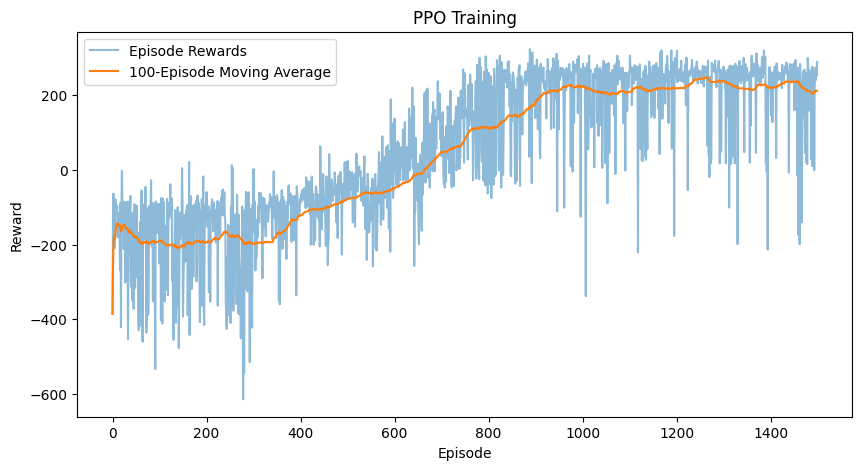


------------ Training Complete:) Recording Final Demonstration Video ------------------------

----------- Recording Final Training Episode -----------


final episode completed with reward: 232.10 in 372 steps
saving final episode video to lunar_lander_final_episode.mp4
saving as gif to lunar_lander_final_episode.gif


video displayed successfully :)


In [ ]:
if __name__ == "__main__":
    trained_agent = train_ppo_agent(
        env_name='LunarLander-v2',
        num_episodes=1500,#1000  500
        max_steps=1000,
        update_interval=2048,
        render_interval=100,
        save_interval=200
    )


  #  from google.colab import files
#files.download("final_episode.mp4") or .gif
